# **Detecting Suicidal Ideation on Reddit Post**

#### Importing Libraries

In [1]:
import pandas as pd #saving .csv files
import re #used to remove non-alpha char
import spacy #used in tokenisation and lemmatisation
from sklearn.model_selection import train_test_split #to split the dataset
from sklearn.feature_extraction.text import TfidfVectorizer #for vectorisation
from sklearn.linear_model import LogisticRegression #for importing the method model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # for evaluation and classification
from scipy.sparse import save_npz, load_npz #for .npz files
import pickle #saving and loading files
import matplotlib.pyplot as plt #to plot and display
import seaborn as sns #for confusion matrix

In [2]:
MODEL_FILE = 'logistic_regression_model.pkl' # File name for the saved model and vectorizer
VECTORIZER_FILE = 'tfidf_vectorizer.pkl'

df = pd.read_csv('Suicide_Detection.csv') # Loading the dataset

# Remove rows with missing values in 'text'
df = df.dropna(subset=['text'])

##### Preview of the Dataset

In [3]:
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


#### Preprocessing the Dataset and Vectorization

In [4]:
# Cleaning the data ( Preprocessing ) 
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    return text

df['cleaned_text'] = df['text'].apply(clean_text)

# Tokenization and lemmatization using spaCy
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

df['lemmatized_text'] = df['cleaned_text'].apply(lemmatize_text)

# Train-Test Split
X = df['lemmatized_text']
y = df['class']  # Replace 'class' with the actual column name for your labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Save preprocessed data, TF-IDF matrices, and vectorizer
df.to_csv('processed_dataset.csv', index=False)
save_npz('X_train_tfidf.npz', X_train_tfidf)
save_npz('X_test_tfidf.npz', X_test_tfidf)
pd.DataFrame(y_train).to_csv('y_train.csv', index=False)
pd.DataFrame(y_test).to_csv('y_test.csv', index=False)

with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

print("Preprocessed data, labels, and TF-IDF vectors saved.")


Preprocessed data, labels, and TF-IDF vectors saved.


##### Preview of the Preprocessed Data

In [4]:
df = pd.read_csv('processed_dataset.csv')
df.head()

,Unnamed: 0,text,class,cleaned_text,lemmatized_text
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,ex wife threatening suiciderecently i left my ...,ex wife threaten suiciderecently leave wife go...
1,3,Am I weird I don't get affected by compliments...,non-suicide,am i weird i dont get affected by compliments ...,weird not affect compliment come know irl feel...
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,finally is almost over so i can never hear h...,finally hear bad year swear fuck god annoying
3,8,i need helpjust help me im crying so hard,suicide,i need helpjust help me im crying so hard,need helpjust help m cry hard
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,im so losthello my name is adam and ive been ...,m losthello adam ve struggle year m afraid p...


#### **Training the Logistic Regression Model**

In [6]:
#Loadign the preprocessed TF-IDF matrices
X_train_tfidf = load_npz('X_train_tfidf.npz')
X_test_tfidf = load_npz('X_test_tfidf.npz')

# Training the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_tfidf, y_train)

# Saving the trained model for future use
with open('logistic_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model trained and saved.")

Model trained and saved.


#### Loading the Trained Model and Vectorizer

In [5]:
try:
    df = pd.read_csv('processed_dataset.csv') # Loading preprocessed dataset

    # Loadign TF-IDF vectors
    X_train_tfidf = load_npz('X_train_tfidf.npz')
    X_test_tfidf = load_npz('X_test_tfidf.npz')

    # loading train adn test data
    y_train = pd.read_csv('y_train.csv').values.ravel()
    y_test = pd.read_csv('y_test.csv').values.ravel()
    
    with open('vectorizer.pkl', 'rb') as f:
        vectorizer = pickle.load(f)
    with open('logistic_model.pkl', 'rb') as f:
        model = pickle.load(f)

    print("Preprocessed data, labels, and model loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}. Please run the preprocessing and training blocks first.")

Preprocessed data, labels, and model loaded successfully.


### **Testing the Model**

In [6]:
# Make predictions
y_pred = model.predict(X_test_tfidf)

#### Evaluating Model Accuracy and Plotting Graphs

Accuracy: 0.9301
Classification Report:
              precision    recall  f1-score   support

 non-suicide       0.92      0.94      0.93     23287
     suicide       0.94      0.92      0.93     23128

    accuracy                           0.93     46415
   macro avg       0.93      0.93      0.93     46415
weighted avg       0.93      0.93      0.93     46415

Confusion Matrix:
[[21863  1424]
 [ 1819 21309]]


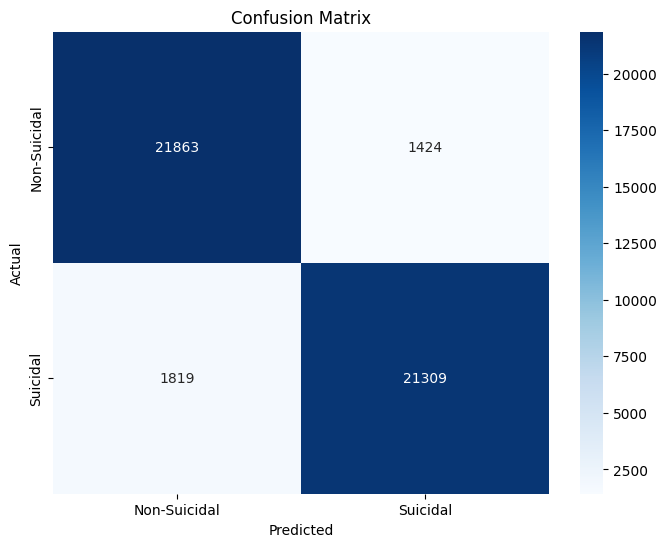

In [7]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Suicidal', 'Suicidal'], 
            yticklabels=['Non-Suicidal', 'Suicidal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Predicting the User Input

In [11]:
## Function to predict the class (Suicidal or Non-Suicidal) of a user input
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'@\w+', '', text)  # remove mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove special characters
    return text

nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

def predict_input(input_text):
    cleaned_text = clean_text(input_text)
    
    lemmatized_text = lemmatize_text(cleaned_text)
    
    input_tfidf = vectorizer.transform([lemmatized_text])
    
    prediction = model.predict(input_tfidf)
    
    prob = model.predict_proba(input_tfidf)[0]
    
    if prob[1] > 0.5: 
        result = "Suicidal"
    else:
        result = "Non-Suicidal"
    
    #result
    print(f"Prediction: {result}")
    print(f"Probabilities: Non-Suicidal: {prob[0]:.4f}, Suicidal: {prob[1]:.4f}")
    
input_text = input("Please enter a sentence: ")
predict_input(input_text)

Please enter a sentence:  i had the best day of my life :D


Prediction: Non-Suicidal
Probabilities: Non-Suicidal: 0.5172, Suicidal: 0.4828


# --End of Code--